<a href="https://colab.research.google.com/github/Noam-Coh3n/MLLM_practical/blob/main/Practical_Notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Notebook 2. 15 pts total

---
Please ensure you save a copy of this notebook to your Google Drive. You will not be able to save answers in this version.
---


This is the second practical notebook, again based on [Marks and Tegmark (2023) The Geometry of Truth](https://arxiv.org/abs/2310.06824).

In this notebook, you will be examining the internal activations of a language model to understand where the language model stores information about truth and falsity, how we can extract a true/false direction within the model's activations, and how we can alter a language model's output but altering these activations.

Concretely, you will:
1. (5 pts) Work with the city locations dataset from the first notebook to calculate accuracy on a slightly larger model, use activation patching to identify the region of the model that encodes truth and falsity, and build classifiers over the activations from this region.
2. (7 pts) Work with a new dataset to implement activation patching, extract activations from the model, visualise with PCA, and examine how well the classifiers from the first dataset generalise to the second.
3. (3 pts) Show that the output of the model can be 'steered' from false to true by systematically altering the values of the activations at the relevant regions.

**Note** Unless explicitly stated, you may use functions from packages. For example, to calculate accuracy, you can use the scikit-learn function.

Some of the content of this notebook is taken from the following tutorial:
https://nnsight.net/notebooks/mini-papers/marks_geometry_of_truth/. Please do read this tutorial for help! However, the tutorial itself is a bit buggy and may be difficult to run.


## 0. Setup
Here, we import the packages we need.

**Note**

In this notebook, we use the Llama-3.2 3B model. Before starting the tutorial, please go to the model's [huggingface page](https://huggingface.co/meta-llama/Llama-3.2-3B) and request permission to use the model. Then, log in with your [huggingface access token](https://huggingface.co/docs/hub/en/security-tokens).

In [ ]:
from IPython.display import clear_output
!pip install nnsight>0.5.0

clear_output()

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# We set some seeds for reproducibility
import random
import torch

random.seed(12)
torch.manual_seed(12)
torch.cuda.manual_seed(12)

In [ ]:
# utility function
def rindex(lst, value):
  """get the rightmost index of a value in a list."""
  return len(lst) - 1 - lst[::-1].index(value)

## Part 1. (5 pts) Working with a dataset of city locations.
You will:

a. (0.5 pt.) Download the city locations dataset (link given below), split into train and test, and calculate accuracy over the train split.

b. (0.5 pt.) We will see how to identify the part of the model that encodes truth and falsity. You will visualise truth and falsity in the model using PCA.

c. (1 pt.) Run a linear classifier over the activations of the model.

d. (3 pt.) Write code for the mean mass classifier and use it to classify the model activations.

In [ ]:
# We first of all import the model and (optionally) look at its internal structure
import nnsight
from IPython.display import clear_output

model = nnsight.LanguageModel("meta-llama/Llama-3.2-3B", device_map="auto")

clear_output()
# print(model)

We set up our prompt template, as we did in the first notebook.

In [ ]:
# We set up a prompt to see if models can correctly classify true and false statements.
PROMPT_TEMPLATE_LOC = """The city of Tokyo is in Japan. This statement is: TRUE
The city of Hanoi is in Poland. This statement is: FALSE
{statement} This statement is:"""

source_statement_loc = "The city of Toronto is in Canada." # true
source_prompt_loc = PROMPT_TEMPLATE_LOC.format(statement=source_statement_loc)
base_statement_loc = "The city of Chicago is in Canada." # false
base_prompt_loc = PROMPT_TEMPLATE_LOC.format(statement=base_statement_loc)

# This statement should output FALSE if we give it to the model.
print(base_prompt_loc)

### Part 1a. (0.5 pt)
Load the city locations dataset, split into train and test, and evaluate the performance of the model on the train split. You can use code from Practical Notebook 1 to help with this.

In [ ]:
# Load the city locations dataset and split into train and test
# Link: https://raw.githubusercontent.com/saprmarks/geometry-of-truth/refs/heads/main/datasets/cities.csv

# YOUR CODE HERE


In [ ]:
# Run the model over the train split and save the predictions

# YOUR CODE HERE


In [ ]:
# Convert the predictions into numerical values and calculate accuracy.

# YOUR CODE HERE

You should see that the model has high accuracy across the train dataset. Now, we will choose one pair of sentences - the 'source_prompt_loc' and 'base_prompt_loc' we defined above, and evaluate the model on just that pair of sentences. Again, we will see that the model correctly outputs 'True' and 'False' for these sentences.

In [ ]:
# does the model know that Chicago isn't in Canada?
with torch.no_grad():
  with model.trace(base_prompt_loc) as trace:
    # save the model's output logits
    logits = model.output.logits.save()

# what's the model's response?
print(base_prompt_loc.split('\n')[-1])
print(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))

In the cell below, we evaluate the model on our source prompt, and save the activations. We will use these to understand where in the model truth and falsity is encoded.

In [ ]:
# does the model know that Toronto is in Canada?
source_activations = []
with torch.no_grad():
  with model.trace(source_prompt_loc) as trace:
    # At each layer, we save the model activations
    for layer in model.model.layers:
      source_activations.append(layer.output[0].save())
    # save the model's output logits
    logits = model.output.logits.save()

print(source_prompt_loc.split('\n')[-1])
print(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))

In [ ]:
# Let's check the dimensions of the activations
print(f'We have {len(source_activations)} lists of activations, one for each layer.')
print(f'Each list of activations is {len(source_activations[0])} long, \
corresponding to the number of tokens in the source prompt.')
print(f'The activations for each token at each layer are \
{len(source_activations[0][0])} long, corresponding to the hidden dimension of the model.\n\
See the model structure we printed earlier to check this.')

### Part 1b. Activation Patching

**Note**: The points in this section are only for the PCA analysis: the rest is exposition.

We now use a technique called *activation patching* to determine which parts of the model affect whether 'TRUE' or 'FALSE' is output.

In order to do this, we run the model over the base prompt, i.e.

  ```
  The city of Tokyo is in Japan. This statement is: TRUE
  The city of Hanoi is in Poland. This statement is: FALSE
  The city of Chicago is in Canada. This statement is:
  ```
As we saw earlier, the model should output FALSE when prompted with this statement.

We will run the model over the base prompt. At each layer, and at each token in the layer, we will replace the activations produced by the base (FALSE) prompt, with the activations produced by the source (TRUE) prompt. This will allow us to see which layer and which token has most effect on the output of the model.


In [ ]:
# We run the model over the base prompt (false), replace activations with
# activations from the source prompt (true) and measure P(TRUE) - P(FALSE),
# i.e., does replace that token activation at that layer change the output towards TRUE?
from tqdm import trange

# The below gets us the token ids of the tokens " TRUE" and " FALSE".
# Why do we do input_ids[1]?
# This is because when we give the tokenizer a string, it prepends the token ids
# of the string with a "beginning of sequence" token id. In this case it is 128000.
# If you print out the input_ids of any sequence, it will start with the token id 128000
true_token_id = model.tokenizer(" TRUE").input_ids[1]
false_token_id = model.tokenizer(" FALSE").input_ids[1]

# Here, we get the token ids of the source prompt
source_prompt_ids = model.tokenizer(source_prompt_loc).input_ids
newline_token_id = model.tokenizer('\n').input_ids[1]
# And we find the start of the final example, i.e. the start of:
# "The city of Chicago is in Canada. This statement is:"
last_example_index = rindex(source_prompt_ids, newline_token_id) + 1 # get start of final example

patching_results = [] # save difference P(TRUE) - P(FALSE),
for layer_index in trange(model.config.num_hidden_layers): # loop through layers
  patching_per_layer = []
  for token_index in range(last_example_index, len(source_prompt_ids)): # loop through tokens of the final example
    with torch.no_grad():
      with model.trace(base_prompt_loc):
        # We get the activation of the model for the current layer and token,
        # and replace it with the equivalent activation from the source prompt.
        model.model.layers[layer_index].output[0][token_index, :] = source_activations[layer_index][token_index, :]
        # get model output and convert to probabilities using softmax
        patched_probs = model.output.logits[:, -1].softmax(dim=-1)
        # get probability of generating true vs. false answer
        patched_true_prob = patched_probs[0, true_token_id].item()
        patched_false_prob = patched_probs[0, false_token_id].item()
        # save difference btw true & false answers
        patched_diff = patched_true_prob - patched_false_prob
        patching_per_layer.append(patched_diff.save())
  patching_results.append(patching_per_layer)

So now, for each layer in the model, and for each token in the input, we have calculated the difference that that token makes to the output -- i.e., whether the model outputs TRUE or FALSE.

We will now plot the results.

In [ ]:
# plot results
import matplotlib.pyplot as plt

# We want to understand which tokens affect the ouput of the model, but we can't
# understand the token ids correctly -- they are just number. We therefore
# convert token indices to token strings by decoding the token ids.
base_token_ids = model.tokenizer(base_prompt_loc).input_ids
token_strings = [
  f"{model.tokenizer.decode(base_token_ids[t])}"
  for i, t in enumerate(range(last_example_index, len(base_token_ids)))
]

fig, ax = plt.subplots(figsize=(10,5))

# This command presents the matrix of patching results as a heatmap.
# Darker colours indicate that the activation values of that token at that layer
# has more of an effect on whether the model outputs TRUE or FALSE.
loc_plot = ax.imshow(patching_results, aspect='auto', cmap='Blues', interpolation='none')

# Setting plot details
ax.set_xticks(range(len(base_token_ids)-last_example_index))
ax.set_xticklabels(token_strings)
ax.set_ylabel('Layer')
ax.set_xlabel('Token')
fig.colorbar(loc_plot)
plt.show()

Let's interpret what we are seeing in this plot.

1. Firstly, we see that **the token 'Chicago' makes a difference in what the model outputs**. This makes sense, since we changed this token to having the activations of 'Toronto', and it is the only thing we changed.

2. On the righthand side of the plot, we also see that **the activation of the last token has a large effect**. This also makes sense: the activations of the last token are what determines the next token output.

3. In the middle of the plot, we see something interesting: around layer 8, **the activations of the token 'Canada' also make a big difference to the output**. In the paper, Marks and Tegmark interpret this as being where information about truth and falsity of statements is stored.

(In fact, Marks and Tegmark use the full stop '.' token, but in this model, the last token before the full stop looks as if it has more effect).

We will now extract these activations from the model across the training and test datasets, and visualise them using PCA.


#### 0.5 pts Using PCA to visualise activations



Now that we've identified **where** an LM represents the truth of a statement, let's investigate **how** it represents this information. To start, we'll visualize the representations of true and false statements, projecting them to a lower dimension using PCA.

In [ ]:
# We are going to collect the activations of the final sentence token at the 8th layer
LAYER = 8

# We use the model.tokenizer to get the token id of '.'
punctuation_token_id = model.tokenizer('.').input_ids[1]

activations=[]
# Loop through the train dataset
for i in trange(len(Xtrain)):
  # Get the statement
  statement = Xtrain.iloc[i]
  # form the prompt
  prompt = PROMPT_TEMPLATE_LOC.format(statement=statement)
  # Use model.tokenizer to generate the input ids of the prompt
  prompt_token_ids = model.tokenizer(prompt).input_ids

  # Get the index of final token in the sentence (before the ".")
  final_token_index = rindex(prompt_token_ids, punctuation_token_id) - 1

  with torch.no_grad():
    with model.trace(prompt) as trace:
      # get the model's activation at our chosen layer (LAYER) and token position (final_token_index)
      activation = model.model.layers[LAYER].output[0][final_token_index, :].save()
      # add to our list of activations!
      activations.append(activation.unsqueeze(0))

#  We now form the list into a tensor of activations
train_activations=torch.cat(activations)

We now use PCA to visualise the activations. Firstly, we move the activations to the CPU. They are now in the form of a numpy array, and you can use PCA to reduce their dimensionality to 2.

In [ ]:
# We now convert the train_activations to numpy, and move to the cpu.
train_activations = train_activations.detach().cpu().numpy()

# 0.5 pts Use PCA to reduce the dimensionality of the activations to 2

## YOUR CODE HERE


Now, plot the 2d PCA components on a scatter plot, using different colours for the activations corresponding to true statements and false statements. You should get something resembling the following:
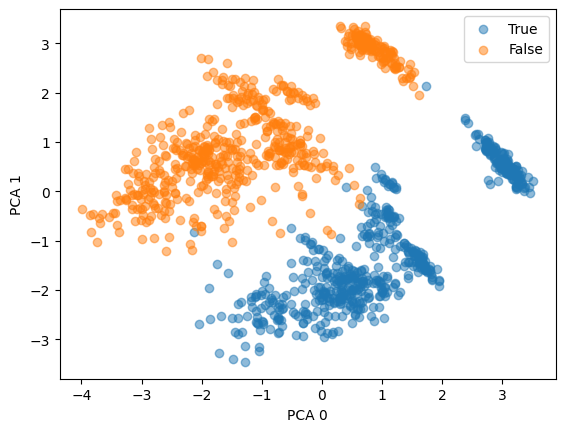



In [ ]:
# Plot the activations for true and false statments.
# To get the activations for true statements, you can index into an array using
# logical indexing. For example:
# x = np.array([1, 2, 3, 4, 5])
# y = np.array([0, 0, 1, 0, 1])
# x[y==0] will return np.array([1, 2, 4])

## YOUR CODE HERE


You should see that the activations for true and false statements separate neatly into separate clusters.

 Now, we will do the same for the test set, and build a classifier over the train activations.

### Part 1c. (1 pt) Building a classifier over the activations.

In this section, you will:

i. (0.5 pt) Run the model over the test set and collect the activations.

ii. (0.5 pt) Train a logistic regression on the train set and evaluate on the train and test splits.

In [ ]:
# Firstly, we will delete some variables from the GPU and empty the cache to free up space.
import gc

del activations

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# 0.5 pt:

# Collect the activations for the test set, save to a variable test_activations,
# and send to the cpu.
activations=[]

## FILL IN THE CODE BELOW
# Loop through the test dataset
for i in trange(len(Xtest)):

  # Get the statement at iloc i

  # Set up the prompt and get the prompt token ids

  # get index of final token in the sentence (before the ".")

  # Using torch.no_grad and a model trace, collect the activations.
  with torch.no_grad():
    with model.trace(prompt) as trace:
      # get the model's activation at our chosen token & layer position

      # append to activations


test_activations=test_activations.detach().cpu().numpy()


In [ ]:
# 0.5 pts:
# Build a logistic regression classifier over the train activations and assess
# the performance of the classifier over the training and test sets.
# Print out the training and test accuracy.

## YOUR CODE HERE

You should get very high accuracy for this classifier -- around 99%. This shows that the activations for this token are almost completely linearly separable into TRUE and FALSE categories. This accords with what we saw in the PCA plot.


### Part 1d. 3 pts. Building a Mass-Mean Probe

You should find that the logistic regression classifier obtains very high accuracy. However, as argued in the paper, this classifier doesn't necessarily give us a representation of the true-false direction.

Instead, the paper introduces a Mass-Mean Probe. The idea behind this is as follows. We can get a direction in activation space that represents the difference between true and false by taking the mean of the activations representing true sentences, the mean of the activations representing false sentences, and subtracting the second from the first.

Taking $T = $ the set of true sentences, $F = $ the set of false sentences, and $\mathbf{act}_s$ a vector of activations for our chosen layer and token for a given sentence $s$, we have:

$$ \mathbf{diff} = \overline{\mathbf{act}_{T}} - \overline{\mathbf{act}_{F}} $$

where $\overline{\mathbf{act}_{T}} = \frac{1}{|T|}\sum_{s \in T}\mathbf{act}_s$, i.e. the mean activations over the true sentences.

So we have a direction from false to true. We can make this into a classifier as follows:

$$p(true|s) = \sigma(\mathbf{diff}\cdot\mathbf{act}_s)$$ where $\sigma(x) = \frac{1}{1+e^{-x}}$

If the activation $\mathbf{act}_s$ is closer to the mean of the true sentences, $p(true|s)$ will be higher, and if it is close to the mean of the false sentences, it will be lower.

We now implement this classifier.

In [ ]:
import numpy as np

# Sigmoid function for you to use
def sigmoid(x):
  return 1/(1+np.exp(-x))


# Building the probe (1.5 pt)

# 0.5 pt
# First, write a function that takes a set of activations and a set of labels
# and returns the difference in means
def mm_diff(activations, labels):
  # Calculate the mean of the activations of true statements
  ## YOUR CODE HERE

  # calculate the means of the activations of false statements
  ## YOUR CODE HERE

  # Calculate the difference between them and return
  ## YOUR CODE HERE
  return difference_in_means

# 1 pt
# Write a classifier that takes activations, labels, and
# optionally the difference in means, and returns an array of true/false
# predictions corresponding to the given activations. Predictions can be in the
# form 1/0 or True/False
def mm_classifier(activations, labels, difference_in_means=None):
  # if the difference_in_means is given, use that, otherwise calculate it using
  # the function you wrote previously
  if difference_in_means is not None:
    ## YOUR CODE HERE
  else:
    ## YOUR CODE HERE

  # For the given activations, calculate their dot product with the difference_in_means
  ## YOUR CODE HERE

  # Calculate the sigmoid of the dot products
  ## YOUR CODE HERE

  # Predict True (or 1) if the sigmoid of the dot product is greater than 0.5,
  # else False (or 0).
  ## YOUR CODE HERE

  return preds




0.5 pt: Fit the classifier to the train set and calculate the accuracy of the classifer over the train and test sets.

Now we will run the classifier on the train and the test set and calculate the accuracy.

When you run the classifier on the test set, make sure to use the difference in means from the train set.

Compare the accuracy on the test set between this model and the linear regression. Are they significantly different?

In [ ]:
# Get predictions on the train set
## YOUR CODE HERE

In [ ]:
# Get predictions on the test set **using the difference in means from the train set**
## YOUR CODE HERE

In [ ]:
# Calculate the accuracy for train and test
## YOUR CODE HERE

In [ ]:
# 1 pt
# Use bootstrapping to determine whether the test accuracy of the mean-mass probe
# and the logistic regression are significantly different.
## YOUR CODE HERE

## Part 2. (7 pt) Working with a new dataset
We now use a new dataset of cities and their populations. Download the us_cities_population.csv from Canvas and save it to your Google Drive. You can then mount your Google Drive and access the csv.

The csv contains details of the city, state, population, and a label which is 1 if the population is greater than 300,000 -- i.e. the city is large -- and 0 otherwise.

You will:

a. (1 pt) Calculate the performance of the model over this new dataset.

b. (2.5 pt) Run activation patching and plot the difference in probabilities.

c. (2.5 pt) Generate scatter plots of the first 2 PCA components.

d. (1 pt) Use a logistic regression and a mean mass probe to classify the activations.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/your/path/here/us_cities_population.csv')
df.head()

In [ ]:
# We will use the following prompt, source, and base statments.
PROMPT_TEMPLATE_POP = """Bend, OR, is a large city. This statement is: FALSE
Houston, TX, is a large city. This statement is: TRUE
{statement} This statement is:"""

source_statement_pop = "Los Angeles, CA, is a large city." # true
source_prompt_pop = PROMPT_TEMPLATE_POP.format(statement=source_statement_pop)
base_statement_pop = "Des Moines, IA, is a large city." # false
base_prompt_pop = PROMPT_TEMPLATE_POP.format(statement=base_statement_pop)

# False statement
print(base_prompt_pop)

### Part 2a. (1 pt)
Run the model over the new dataset, collect the predictions, and calculate the accuracy.

In [ ]:
# Run the model over the new dataset and collect the predictions.
# Calculate the accuracy of the model - this should be somewhere around 80%

## YOUR CODE HERE

We now check that the model outputs the correct judgement for the source and base statements:

In [ ]:
# does the model know that Des Moines is not a large city?
with torch.no_grad():
  with model.trace(base_prompt_pop) as trace:
    # save the model's output logits
    logits = model.output.logits.save()

# what's the model's response?
print(base_prompt_pop.split('\n')[-1])
print(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))

In [ ]:
# does the model know that LA is a large city?
source_activations = []
with torch.no_grad():
  with model.trace(source_prompt_pop) as trace:
    # let's save the intemediate activations - we'll use them in the next step!
    for layer in model.model.layers:
      source_activations.append(layer.output[0].save())
    # save the model's output logits
    logits = model.output.logits.save()

print(source_prompt_pop.split('\n')[-1])
print(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))

### Part 2b. (2.5 pts)
Run activation patching from the source to the base statements, measure the difference in probabilities, and plot the results.

In [ ]:
# 2pts:
# Run activation patching from the source to the base statements

# Get the TRUE and FALSE token ids
## YOUR CODE HERE


#Get the source prompt ids and compute the index at which the last example starts
## YOUR CODE HERE

# NB: The number of tokens in the source and base prompts should be the same for this to work.

patching_results = [] # save interchange intervention accuracies
# Loop through layers
for layer_index in trange(model.config.num_hidden_layers): # loop through layers
  patching_per_layer = []
  # Loop through tokens in base prompt
  for token_index in range(last_example_index, len(base_prompt_ids)):
    with torch.no_grad():
      with model.trace(base_prompt_pop):
        # Patch the source activations into the base activations
        ## YOUR CODE HERE

        # get model output and convert to probabilities using softmax
        ## YOUR CODE HERE

        # get probability of generating true vs. false answer
        ## YOUR CODE HERE

        # save difference between true & false answers
        ## YOUR CODE HERE

  patching_results.append(patching_per_layer)

In [ ]:
# (0.5 pt) Plot the results
import matplotlib.pyplot as plt

## YOUR CODE HERE

You should see that the model stores information about the truth and falsity of the model somewhere around the 8th layer again, and that it should be around the token for ' large' (Notice the space in front of the word!). However, the results are not quite as clear as for the city locations dataset.

### Part 2c. 2.5 pts

One of the claims in the paper is that the true-false direction generalises across datasets. To check this, we will download the activations from the same layer (layer 8), for the ' large' token, visualise the first two PCA components, and run our classifiers over these activations.

In [ ]:
# 2 pts Collect the model's activations over each statement at the same location
from tqdm import trange
import torch

# we'll focus on the 8th layer and the ' large' token
LAYER = ## YOUR CODE HERE
large_token_id = ## YOUR CODE HERE

activations = []
# Loop through dataset
for i in trange(df.shape[0]):
  # Get the relevant row of the dataframe
  ## YOUR CODE HERE

  # Build the statement in the same format as the source and base statements
  ## YOUR CODE HERE

  # and put in the prompt
  ## YOUR CODE HERE

  # Get the relevant token index
  ## YOUR CODE HERE

  # Get the model activations and append to the activations variable.
  with torch.no_grad():
    with model.trace(prompt) as trace:
      # get the model's activation at our chosen token & layer position
      ## YOUR CODE HERE

      # add to our false/true activations!
    activations.append(activation.unsqueeze(0))

activations=torch.cat(activations)

In [ ]:
# send the activations to cpu
all_activations = activations.detach().cpu().numpy()

In [ ]:
# 0.5 pts Reduce dimensionality to 2 using PCA and plot.
## YOUR CODE HERE




### Part 2d. (2 pts) Cross-dataset generalization.
Now, we will test whether the logistic regression classifier and the mean-mass classifiers we built on the city locations dataset generalize to this one. Before you run this code, have a think about what you expect the answers to be.**bold text**

In [ ]:
#  0.5 pt Use the logisitic regression trained on the city location dataset
# to make predictions over the current dataset. Print out the accuracy.
# Is this expected? (You do not need to answer here, but you should discuss in the report).
## YOUR CODE HERE

In [ ]:
#  0.5 pt Use the mean-mass classifier trained on the city location dataset
# to make predictions over the current dataset. I.e., use the difference_in_means
# from the city locations dataset. Print out the accuracy.
# Is this expected? (You do not need to answer here, but you should discuss in the report).
## YOUR CODE HERE

Calculate the performance of the majority baseline classifier, and determine whether the performance of either the difference in means classifier or the logisitic regression classifier is significantly different.

In [ ]:
## YOUR CODE HERE

## Part 3 (3pts) Model steering.
A key result of the paper is that the output of the model can be changed by adding the difference_in_means direction to the model activations. Let's test this out!

We will take all the false statements from the test split for the city location dataset (cities.csv), and try to steer the model towards outputting TRUE.

In [ ]:
# 1 pts
# Get all the false statements from the test split of the city location dataset.
# Run the model over these and get the predictions.
# Calculate how many times the model outputs FALSE.

## YOUR CODE HERE



In [ ]:
# 2 pts
# Run the model over the dataset and add on the difference_in means to the
# relevant activations. You will need to find the index of the token to want to
# alter for each sentence. Save the outputs and calculate how many are now false.

predictions_steered = []

# We need to send the difference_in_means vector to the gpu
difference_in_means = torch.from_numpy(difference_in_means).to('cuda:0')

with torch.no_grad():
  # Run the model over the false statements
  for i in trange(len(false_statements)):
    # Get the statement and build the prompt
    ## YOUR CODE HERE

    # Find the index of the token you will be altering
    ## YOUR CODE HERE

    with model.trace(prompt) as trace:
      # Add on the difference_in_means to the relevant activations
      ## YOUR CODE HERE

    # Append the predictions
    ## YOUR CODE HERE


# Calculate how many are false
## YOUR CODE HERE



## Wrap up

So what have we done in this practical?

In part 1, we assessed the performance of the Llama-3.2-3B model on the city  locations dataset. We identified the area of the model that encodes truth and falsity, and visualised this using PCA. We showed that the relevant activations can be linearly classified and that they can also be classified using a mass mean probe.

In part 2, we identified how the model encodes truth and falsity on a different dataset, using the same analysis. We visualised the activations using PCA, and compared how the logistic regression classifier and the mass mean probe can be generalised to this new dataset.

In part 3, we looked at how the behaviour of the model can be steered by applying the difference in means vector to the area of the model that encodes truth and falsity.

**Now what?**
For another 10 points, you should develop your own question, and use the techniques in this practical and learnt over the course to invesitgate this.

Some ideas, ranging from fairly simple to more complex:
 * In the paper, the mean mass probe is modified using the covariance matrix of the dataset. Make this change and compare the performance across one or two datasets.
 * Test the performance of larger models on these datasets (discuss with me or Jan how larger models can be used).
 * Generate a new dataset and evaluate the model on that. Example: the hyponymy relation: cats are mammals, robins are mammals. Question: do different areas of the model encode truth and falsity depending on whether the subcategory or supercategory is changed?
 * How does the model encode generics? Birds lay eggs is strictly false, but acceptable.
 * In the city population dataset, the model generates correct predictions for very large or small cities. Could the model encode some sort of fuzzy truth value for medium sized cities? How would you investigate that?
 * How is metaphor encoded? Again, metaphors are strictly false, but widely used and understood.

 Feel free to discuss with me and good luck!